In [1]:
import numpy as np
import xbrl.envs as bandits
from xbrl.algs.generalized_linear import UCBGLM, UCBGLM_general
from xbrl.envs.hlsutils import is_hls, derank_hls, hls_rank, random_transform
import matplotlib.pyplot as plt

In [2]:
rng = np.random.RandomState(seed=1)
n_runs = 3
tol = 1e-6

In [3]:
env_seeds = [rng.randint(9999) for _ in range(n_runs)]
env_seeds

[235, 5192, 905]

In [4]:
agent_seeds = [rng.randint(9999) for _ in range(n_runs)]
agent_seeds

[7813, 2895, 5056]

In [5]:
def make_agent(seed, env, algo=UCBGLM):
    return algo(
            env=env,
            seed=seed,
            update_every_n_steps=1,
            delta=0.01,
            ucb_regularizer=1.,
            bonus_scale=1.,
            opt_tolerance=1e-8
        )

## Motivating Example

In [6]:
hls_features = rng.uniform(low=-1., high=1., size=(20, 4, 5))#np.load("../problem_data/basic_features.npy")
dim = hls_features.shape[-1]
hls_param = param = rng.uniform(low=-1., high=1., size=dim)#np.load("../problem_data/basic_param.npy")
assert is_hls(hls_features, hls_features @ hls_param)
horizon = 10000
hls_features.shape

(20, 4, 5)

In [7]:
instance_seeds = [rng.randint(9999) for _ in range(dim)]
instance_seeds

[7725, 6515, 3519, 1133, 1639]

In [8]:
hls_features = np.load("../problem_data/basic_features.npy")
dim = hls_features.shape[-1]
hls_param = np.load("../problem_data/basic_param.npy")
assert is_hls(hls_features, hls_features@hls_param)

def make_env(rank, seed):
    features, param = derank_hls(hls_features, hls_param, newrank=rank, 
                                 transform=True, 
                                 normalize=True, 
                                 seed=instance_seeds[rank-1]) 
    assert hls_rank(features, features @ param, tol=tol) == rank
    return bandits.CBFinite(feature_matrix=features,
                           rewards=features@param,
                           noise="bernoulli",
                           seed=seed)

100%|█| 10000/10000 [01:47<00:00, 93.04it/s, % optimal arm (last 100 steps)=100.
100%|█| 10000/10000 [01:49<00:00, 90.95it/s, % optimal arm (last 100 steps)=100.
100%|█| 10000/10000 [01:51<00:00, 89.33it/s, % optimal arm (last 100 steps)=100.
100%|█| 10000/10000 [01:52<00:00, 88.94it/s, % optimal arm (last 100 steps)=100.
100%|█| 10000/10000 [01:53<00:00, 88.47it/s, % optimal arm (last 100 steps)=100.
100%|█| 10000/10000 [01:55<00:00, 86.48it/s, % optimal arm (last 100 steps)=100.


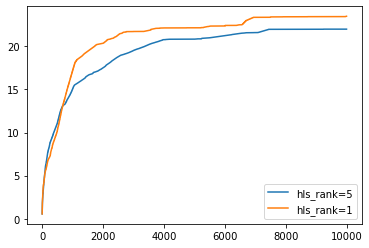

In [9]:
results = []
lines = []
ranks = [5, 1]
for k in range(len(ranks)):
    regrets = []
    results.append([])
    for i in range(n_runs):
        env = make_env(ranks[k], env_seeds[i])
        agent = make_agent(agent_seeds[i], env)
        agent.reset()
        result = agent.run(horizon=horizon)
        results[k].append(result)
        regrets.append(result['expected_regret'])
    regrets = np.array(regrets)
    avg_regret = np.mean(regrets, axis=0)
    line, = plt.plot(avg_regret, label="hls_rank=%d"%ranks[k])
    lines.append(line)
plt.legend(handles=lines)
plt.show()